In [1]:
import matplotlib.pyplot as plt
from hmf import MassFunction
import numpy as np
import pandas as pd
from astropy.cosmology import WMAP7
from scipy.constants import G
import pickle
import fitsio as fio
import images
import tutorial.synthetic.tools as tools
import tutorial.synthetic.render.frame as frame
import tutorial.synthetic.render.render as render
# File directory: inside galaxy clustering. Within same folder as gal_gg_nmgy.pkl/
# Has a tutorial folder with synthetic in. If following my tutorial you only need to paste gal_gmm_nmgy.pkl or modify the path to there.
size = 1000
width = 5000
height = 5000
mean_sources = 0.005
flux_min = 25
flux_max = 350000
galaxy_flux_alpha = 0.48
t_min = 0
t_max = 5
t_alpha = 3
shape_min = 0.01
shape_max = 0.7
shape_alpha = 0.2
bands = ["G", "R", "I", "Z"]
n_bands = 4
reference_band = 1

In [2]:
# Sample mass
mass_min = 10**14 * 1.989*10**33 # Minimum value of the range solar mass
mass_max = 10**15.5 * 1.989*10**33 # Maximum value of the range
hmf = MassFunction()
hmf.update(Mmin=14, Mmax = 15.5) 
mass_func = hmf.dndlnm
mass_sample = []
while(len(mass_sample) < size):
    index = np.random.randint(0, len(mass_func))
    prob = (mass_func/sum(mass_func))[index]
    if np.random.random() < prob:
        mass_sample.append((mass_max-mass_min)/len(mass_func)*index + mass_min)

In [3]:
# Sample redshift
redshift_samples = np.random.uniform(0.2, 0.5, size)

In [4]:
# Calculate individual zis
def zi_based_Z(z, mass, size):
    delta = (WMAP7.H(z).value/100*mass/(10**15*1.989*10**33))**(1/3)*1082.9/299792.458
    temp = np.random.normal(z, delta, size)
    temp = [max(0, x) for x in temp]
    return temp

# Calculate radius based on mass and redshift
def R_based_Z_M(mass, z):
    pho_z = WMAP7.critical_density(z).value
    return (mass/(4/3*np.pi*pho_z))**(1/3)

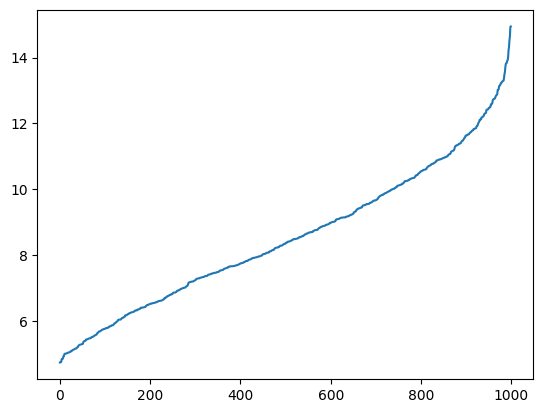

In [5]:
# Get radius based on mass and redshift in cm.
radius_samples = []
for i in range(size):
    radius_samples.append(R_based_Z_M(mass_sample[i], redshift_samples[i])/(3.086*10**24))
plt.plot(sorted(radius_samples))

In [6]:
# Determine # of galaxies
n_galaxy_cluster = []
for i in range(size):
    n_galaxy_cluster.append(int(((mass_sample[i]/(1.989*10**33))/(2.2*10**13))**(1/1.4)*20))

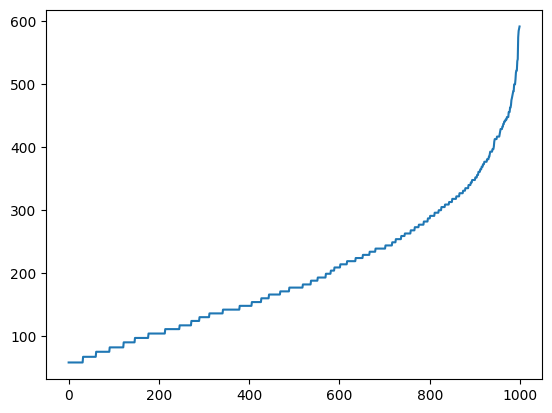

In [7]:
plt.plot(sorted(n_galaxy_cluster))

In [8]:
# Sample center
center_sample = []
x_coords = np.random.uniform(width * 0.3, width * 0.7, size)
y_coords = np.random.uniform(height * 0.3, height * 0.7, size)
center_sample = np.vstack((x_coords, y_coords)).T

In [9]:
scale_pixels_per_au = 100  
radius_samples = [x*scale_pixels_per_au for x in radius_samples]  

galaxy_locs_cluster = []
for i in range(size):
    center_x, center_y = center_sample[i]
    samples = []
    while(len(samples) < int(n_galaxy_cluster[i])):
        angles = np.random.uniform(0, 2 * np.pi, 1)
        radii = np.random.uniform(0, radius_samples[i], 1)  
        sampled_x = float(center_x + radii * np.cos(angles))  
        sampled_y = float(center_y + radii * np.sin(angles))
        if sampled_x >= 0 and sampled_x < width and sampled_y >= 0 and sampled_y < height:
            samples.append([sampled_x, sampled_y])
    while(len(samples) < 1.5*int(n_galaxy_cluster[i])):
        angles = np.random.uniform(0, 2 * np.pi, 1)
        radii = np.random.uniform(radius_samples[i] + 0.001, 2*radius_samples[i], 1)  
        sampled_x = float(center_x + radii * np.cos(angles))  
        sampled_y = float(center_y + radii * np.sin(angles))
        if sampled_x >= 0 and sampled_x < width and sampled_y >= 0 and sampled_y < height and np.random.random() > (((sampled_x - center_x)**2 + (sampled_y - center_y)**2)**0.5 - radius_samples[i])/radius_samples[i]:
            samples.append([sampled_x, sampled_y])
    galaxy_locs_cluster.append(samples)

865.1274955832424


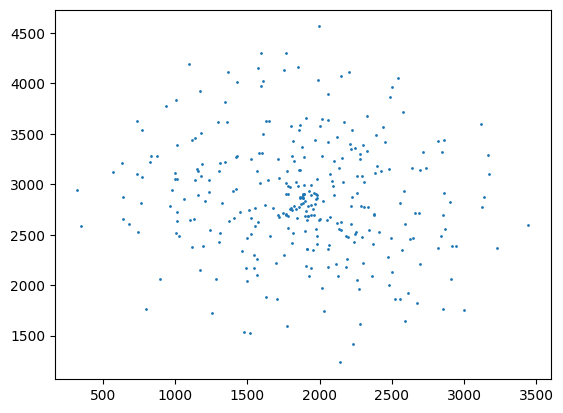

In [10]:
print(radius_samples[10])
plt.scatter([tup[0] for tup in galaxy_locs_cluster[10]], [tup[1] for tup in galaxy_locs_cluster[10]], s = 1)

In [11]:
n_galaxy = np.random.poisson(mean_sources*width*height/49, size)

In [12]:
for i in range(size):
    n_galaxy[i] -= n_galaxy_cluster[i]

In [13]:
galaxy_locs = []
for i in range(size):
    x = np.random.uniform(0, width, n_galaxy[i])
    y = np.random.uniform(0, height, n_galaxy[i])
    galaxy_locs.append(np.column_stack((x, y)))

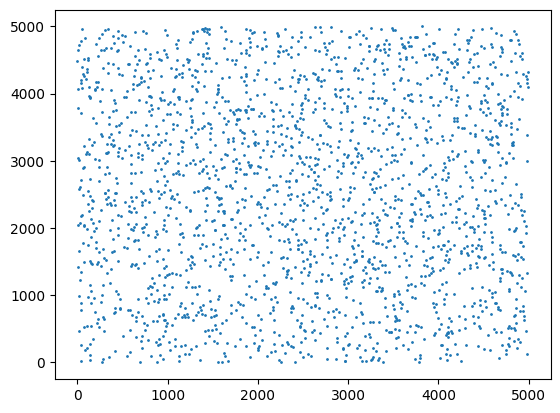

In [14]:
plt.scatter(galaxy_locs[10][:, 0], galaxy_locs[10][:, 1], s = 1)

In [15]:
def cartesian2geo(coordinates, sky_center=(50.64516228577292, -40.228830895890404), pixel_scale=0.2, image_offset=(2499.5, 2499.5)):
    geo_coordinates = []
    for i in range(len(coordinates)):
        temp = []
        for j in range(len(coordinates[i])):
            ra = (coordinates[i][j][0] - image_offset[0])*pixel_scale / (60*60) + sky_center[0]
            desc = (coordinates[i][j][1] - image_offset[1])*pixel_scale / (60*60) + sky_center[1]
            temp.append((ra, desc))
        geo_coordinates.append(temp)
    return geo_coordinates

In [16]:
geo_galaxy = cartesian2geo(galaxy_locs)
geo_galaxy_cluster = cartesian2geo(galaxy_locs_cluster)

In [17]:
def draw_truncated_pareto(alpha, min_x, max_x, n_samples):
    # draw pareto conditioned on being less than f_max
    u_max = 1 - (min_x / max_x) ** alpha
    uniform_samples = np.random.random(n_samples) * u_max
    return min_x / (1.0 - uniform_samples) ** (1 / alpha)

In [18]:
def draw_truncated_pareto(alpha, min_x, max_x, n_samples):
    # draw pareto conditioned on being less than f_max
    u_max = 1 - (min_x / max_x) ** alpha
    uniform_samples = np.random.random(int(n_samples)) * u_max
    return min_x / (1.0 - uniform_samples) ** (1 / alpha)

In [19]:
flux_samples = []
t_size_samples = []
G1_size_samples = []
G2_size_samples = []
for i in range(size):
    total_element = len(galaxy_locs[i]) + len(galaxy_locs_cluster[i])
    flux_samples.append(draw_truncated_pareto(galaxy_flux_alpha, flux_min, flux_max, total_element))
    t_size_samples.append(draw_truncated_pareto(t_alpha, t_min, t_max, total_element))
    G1_size_samples.append(draw_truncated_pareto(shape_alpha, shape_min, shape_max, total_element - total_element//2))
    G1_size_samples[-1] = np.append(G1_size_samples[-1], (-1*draw_truncated_pareto(shape_alpha, shape_min, shape_max, total_element//2)))
    G2_size_samples.append(draw_truncated_pareto(shape_alpha, shape_min, shape_max, total_element - total_element//2))
    G2_size_samples[-1] = np.append(G2_size_samples[-1], (-1*draw_truncated_pareto(shape_alpha, shape_min, shape_max, total_element//2)))

In [20]:
# This gives ["u", "g", "r", "i", "z"] 
with open("gal_gmm_nmgy.pkl", "rb") as f:
    gmm_gal = pickle.load(f)


/home/shihangl/bliss/.venv/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
def galaxy_flux_ratio(size, gmm_gal):
    # ["G", "R", "I", "Z"]
    flux_logdiff, _ = gmm_gal.sample(size)
    flux_logdiff = flux_logdiff[:][:, 1:]
    flux_logdiff = np.clip(flux_logdiff, -2.76, 2.76)        
    flux_ratio = np.exp(flux_logdiff)
    flux_prop = np.ones((flux_logdiff.shape[0], n_bands))
    for band in range(reference_band - 1, -1, -1):
        flux_prop[:, band] = flux_prop[:, band + 1] / flux_ratio[:, band]
    for band in range(reference_band + 1, n_bands):
        flux_prop[:, band] = flux_prop[:, band - 1] * flux_ratio[:, band - 1]
    return flux_prop

In [22]:
def flux2mag(flux, constant=29.5):
    return -2.5*np.log10(flux) + constant

In [32]:
def make_catalog(gmm_gal, flux_samples, t_size_samples, G1_size_samples, G2_size_samples,geo_galaxy, geo_galaxy_cluster, galaxy_locs, galaxy_locs_cluster):
    res = []
    for i in range(3):
        ratios = galaxy_flux_ratio(len(geo_galaxy_cluster[i]) + len(geo_galaxy[i]), gmm_gal)
        fluxes = np.array(flux_samples[i])[:, np.newaxis] * np.array(ratios)
        mock_catalog = pd.DataFrame()
        mock_catalog["RA"] = np.append(np.array(geo_galaxy_cluster[i])[:, 0], np.array(geo_galaxy[i])[:, 0])
        mock_catalog["DEC"] = np.append(np.array(geo_galaxy_cluster[i])[:, 1], np.array(geo_galaxy[i])[:, 1])
        mock_catalog["X"] = np.append(np.array(galaxy_locs[i])[:, 0], np.array(galaxy_locs_cluster[i])[:, 0])
        mock_catalog["Y"] = np.append(np.array(galaxy_locs[i])[:, 1], np.array(galaxy_locs_cluster[i])[:, 1])
        mock_catalog["FLUX_R"] = fluxes[:, 1]
        mock_catalog["MAG_R"] = -2.5*np.log10(mock_catalog["FLUX_R"]) + 29.5
        mock_catalog["FLUX_G"] = fluxes[:, 0]
        mock_catalog["MAG_G"] = -2.5*np.log10(mock_catalog["FLUX_G"]) + 29.5
        mock_catalog["FLUX_I"] = fluxes[:, 2]
        mock_catalog["MAG_I"] = -2.5*np.log10(mock_catalog["FLUX_I"]) + 29.5
        mock_catalog["FLUX_Z"] = fluxes[:, 3]
        mock_catalog["MAG_Z"] = -2.5*np.log10(mock_catalog["FLUX_Z"]) + 29.5
        mock_catalog["TSIZE"] = t_size_samples[i]
        mock_catalog["FRACDEV"] = 0
        mock_catalog["G1"] = G1_size_samples[i]
        mock_catalog["G2"] = G2_size_samples[i]
        res.append(mock_catalog)
    return res

In [33]:
res = make_catalog(gmm_gal, flux_samples, t_size_samples, G1_size_samples, G2_size_samples,geo_galaxy, geo_galaxy_cluster, galaxy_locs, galaxy_locs_cluster)

In [34]:
file_name_tag = 'test_canvas_dc2_' #
# Pick one you want to see
index = 1
mock_catalog = res[index]
ra_cen = 50.64516228577292
dec_cen = -40.228830895890404
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3
for i, band in enumerate(("g", "r", "i")):
    name =  file_name_tag + band
    print(name)
    fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000, )
    fr.render(nprocess=4) 

test_canvas_dc2_g
starting postage stamp calculations in 4 processes


test_canvas_dc2_r
starting postage stamp calculations in 4 processes
test_canvas_dc2_i
starting postage stamp calculations in 4 processes


In [35]:
ims_all = []
for i, band in enumerate(("g", "r", "i")):
    name = file_name_tag + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_all.append(tmp)

test_canvas_dc2_g.fits
test_canvas_dc2_r.fits
test_canvas_dc2_i.fits


1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


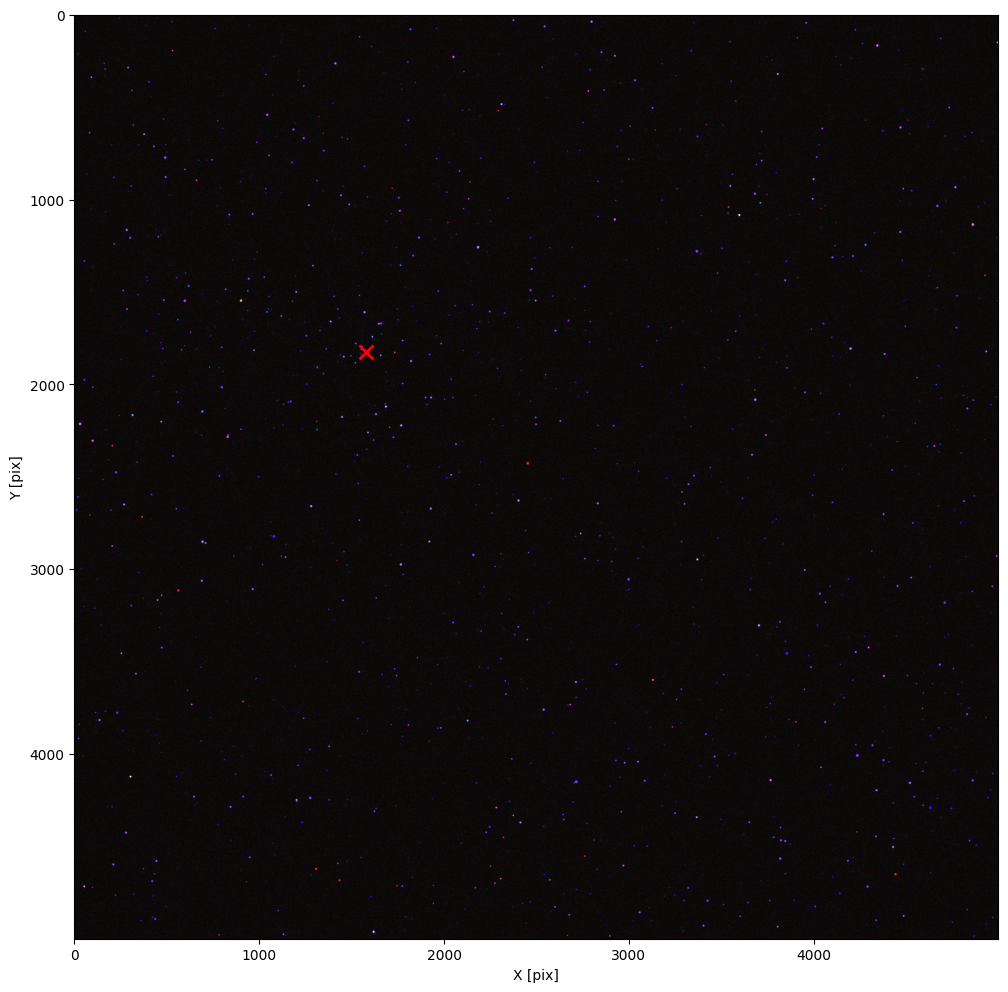

In [36]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2],
                                ims_all[1],
                                ims_all[0],
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * 2, origin='upper')
ax.plot(center_sample[index][0], center_sample[index][1], 'rx', markersize=10, markeredgewidth=2)
# ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("test.png", bbox_inches='tight')